# Fit a dynamical model to sc-flow data

In this notebook, we will

1. Import and visualize simulated single cell flow cytometry data
2. Develop a conditional variational autoencoder that finds a latent space representation, and estimates differentiation rates
3. Visualize the results and compare the inferred values with the ground truth
4. Restrict the model space and improve our estimates

We start by importing some python modules. We will use `torch` and `pyro` for deep learing and variational inference. This is faster on a GPU, but can also be done on a CPU if required. We therefore check if a GPU is available. 

In [1]:
import pandas as pd # for importing the dataset
import matplotlib.pyplot as plt # for plotting
from matplotlib.colors import TABLEAU_COLORS
from sklearn.decomposition import PCA # for dimensionality reduction
import numpy as np # for numerical computations
import tqdm # for progress bars
import torch # PyTorch for tensor computations
import pyro # probabilistic programming library
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam


# allow imports from parent directory (for scdynsys package)

import sys
sys.path.append("..")


# import the dynamical VAE model
from scdynsys.dynamic_vae import VAEgmmdyn

# check if CUDA (GPU) is available and set device accordingly
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

print("CUDA available:", USE_CUDA)


CUDA available: True


## 1. Import the data and visualize

The dataset contains values for 12 flow cytometry markers, and time and celltype information for each cell. The celltype is typically not known, but as this data is simulated, we actually know the celltype. Of course, we should not use this information in our model fitting...

In [2]:
# import the (simulated) dataset
dataset = pd.read_csv('../data/simulated_time_series_data.csv')

# look at the first few rows
dataset.head()

,FSC-A,GFP-A Rag2,PerCP-Cy5-5-A CD21,APC-A AA41,BV421-A IgD,BV510-A CD138,BV711-A CD24,BV786-A B220,BUV395-A,BUV737-A CD23,PE-Texas Red-A Ki67,PE-Cy7-A IgM,Timepoint,CellType
0,-0.214015,0.579805,0.994788,1.287516,-2.701112,-0.073740,0.860941,-1.682623,0.303638,-0.650650,0.969355,0.787402,0.0,T1
1,-0.593347,0.583256,-1.260392,0.585313,0.078244,2.609879,0.162934,0.140665,-0.568422,-0.412455,-0.211297,-2.505118,0.0,T2
2,0.270100,-0.517174,-0.889450,-0.722364,-0.292346,4.463800,1.654122,-1.686419,-0.338157,-1.550371,0.042500,-3.429583,0.0,T2
3,1.244608,0.061091,-0.074230,0.750897,-0.448140,-0.199145,-0.454946,-0.501365,-0.110333,-1.007966,1.595740,0.427172,0.0,T1
4,0.689884,-2.993317,0.963315,0.640652,1.433101,-0.744748,0.401823,0.617740,-0.671283,-0.878362,0.516936,1.098757,0.0,MZ


### Inspection of the data

The dataset contains: 

- 12 flow cytometry markers 
- sampling time information

Let's plot 1-d flow plots (marginal densities) 
and see how these change with time

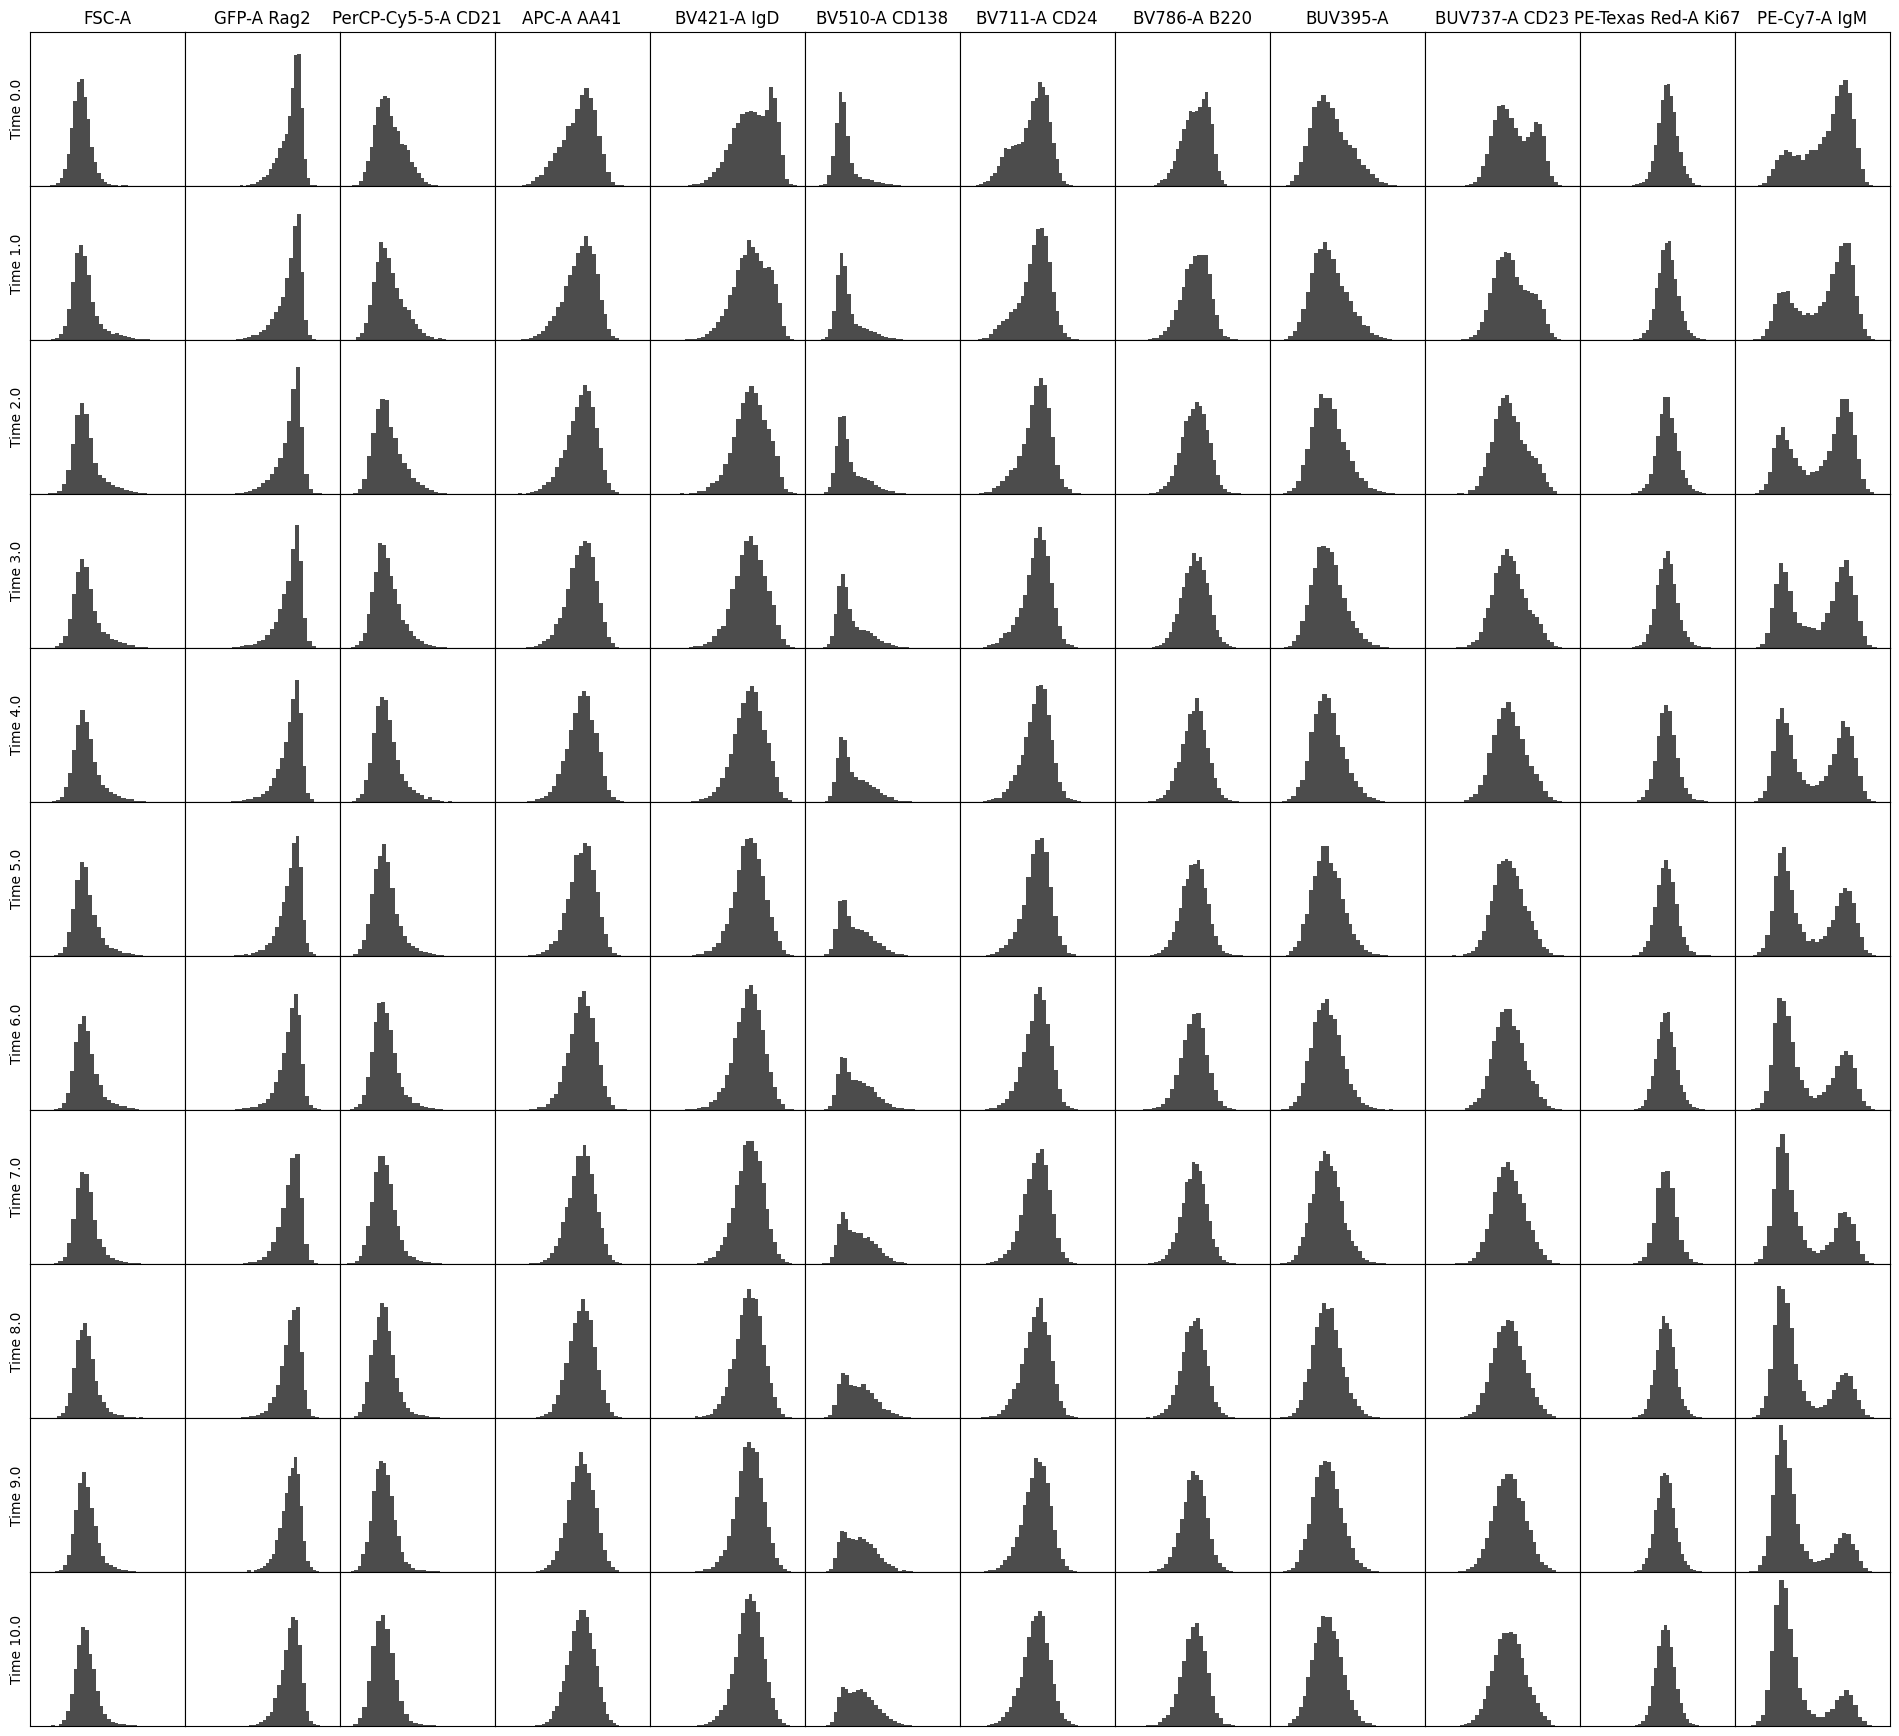

In [3]:
# plot marginal densities of markers at different time points
time_points = sorted(dataset['Timepoint'].unique())
num_timepoints = len(time_points)

# marker names:
markers = [col for col in dataset.columns if col not in ['Timepoint', 'CellType']]
num_markers = len(markers)

fig, axs = plt.subplots(
    num_timepoints, num_markers,
    figsize=(2*num_markers, 2*num_timepoints), 
    sharex='col', sharey=True
)

# remove space between subplots
fig.subplots_adjust(hspace=0.0, wspace=0.0)


# spit data by marker and time point and plot histograms (1D FACS plots)
for j, marker in enumerate(markers):
    for i, tp in enumerate(time_points):
        data_tp = dataset[dataset['Timepoint'] == tp][marker]
        ax = axs[i,j]
        ax.hist(data_tp, bins=30, density=True, color='k', alpha=0.7)
        if j == 0:
            ax.set_ylabel(f'Time {tp}')
        if i == 0:
            ax.set_title(marker)
        ax.set(xticks=[], yticks=[])


The dataset is quite large, and so we'll subsample to speed up
computations. 
Next, we'll define some arrays and tensors that are required below.

These are some of the key elements:

* `xs`: these are the (scaled) marker expression measured by flow cytometry.
* `ts`: time point for each cell.
* `celltypes`: the ground-truth cell type for each cell (only known because we simulate the data)
* `utime`: these are the unique time points in the data set. The reason for using these instead of `ts` is that we only have to evaluate our dynamical model at these time points. If we would evaluate at `ts` we would be doing A LOT of redundant work.

Torch and Pyro work with so-called "tensors" instead of e.g. numpy arrays. So we will conver the "raw" arrays to "tensor". We also move the data to the specified devide (the CPU or the GPU).

In [4]:
# subsample the dataset for faster experimentation

dataset = dataset.sample(50000, random_state=42)

# prepare tensors for model fitting: xs and ts (marker expression and time)

xs_raw = dataset.iloc[:, 0:-1].values
ts_raw = dataset["Timepoint"].values
celltypes = dataset["CellType"].values
celltypes_unique = np.unique(celltypes)
print(f"Unique cell types: {celltypes_unique}")

# torch and Pyro work with tensors: these are arrays with additional functionality
# to support GPU computations and automatic differentiation

xs_tensor = torch.tensor(xs_raw, dtype=torch.float32, device=DEVICE)
ts_tensor = torch.tensor(ts_raw, dtype=torch.float32, device=DEVICE)

# we need to know the data dimension and number of samples

data_dim = xs_tensor.shape[1]  # number of features
n_samples = xs_tensor.shape[0]

print(f"Number of features: {data_dim}, Number of samples: {n_samples}")

# create unique time tensor

utime_raw = np.sort(dataset["Timepoint"].unique())
utime_tensor = torch.tensor(utime_raw, dtype=torch.float32, device=DEVICE)

num_timepoints = len(utime_raw)
print(f"Number of unique time points: {num_timepoints}")

print(f"Unique time points: {utime_raw}")

# create time index tensor

xtime_raw = np.sum([i * (ts_raw == t) for i, t in enumerate(utime_raw)], axis=0)
xtime_tensor = torch.tensor(xtime_raw, dtype=torch.long, device=DEVICE)

# check that the time index tensor is correct

assert torch.all(utime_tensor[xtime_tensor] == ts_tensor)


Unique cell types: ['FM' 'MZ' 'T1' 'T2']
Number of features: 13, Number of samples: 50000
Number of unique time points: 11
Unique time points: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


## 2. Develop a conditional VAE

Using Pyro for building VAE models is relatively easy, as we don't have to manually calculate the ELBO, or worry about ["reparameterization tricks"](https://en.wikipedia.org/wiki/Reparameterization_trick).

However, Pyro has a couple of quirks, leading to a slightly steep learning curve. We therefore provided a working VAE model to make this workshop feasible.

Here, we give an overview of the main components of the VAE model, and we do encourage you to have a look at the model files. They are given in the `scdynsys` folder:

* `dynamic_vae.py`: this contains the main Python class defining our VAE. It has a `model` and a `guide` method, representing the model (including the decoder) and the variational distribution (which Pyro refers to as a "guide").
* `dynamic_model.py`: this is the (solved) ODE model, which also has a `model` and `guide` method such that it can be integrated in the same variational inference loop.
* `mixture_model.py`: As the name suggests: this defines the GMM.
* `nets.py`: These are the encoder and decoder networks.


In this notebook (interactive python session), you might want to run cells multiple times. However, Pyro keeps track of your parameters in a so-called "parameter store". To reset all estimates, you can call the next cell:

In [7]:
# clear Pyro parameter store: erase any previously learned parameters

pyro.clear_param_store()

Next, we initialize the VAE model imported from `scdynsys.dynamic_vae.py`.

Printing the vae gives an overview of all the components. Can you figure out what they all mean?

In [6]:
vae = VAEgmmdyn(
    data_dim = data_dim, 
    z_dim = 3, 
    hidden_dim = 24,
    num_clus = 4,
    use_cuda = USE_CUDA,
)

# print the model architecture:

print(vae)

VAEgmmdyn(
  (decoder_x): DecoderX(
    (fc_in): PyroLinear(in_features=3, out_features=24, bias=True)
    (fc_loc): PyroLinear(in_features=24, out_features=13, bias=True)
    (fc_scale): PyroLinear(in_features=24, out_features=13, bias=True)
    (softplus): Softplus(beta=1.0, threshold=20.0)
  )
  (encoder_z): CondEncoderZ(
    (fc_in): PyroLinear(in_features=14, out_features=24, bias=True)
    (fc_loc): PyroLinear(in_features=24, out_features=3, bias=True)
    (fc_scale): PyroLinear(in_features=24, out_features=3, bias=True)
    (softplus): Softplus(beta=1.0, threshold=20.0)
  )
  (mix): GaussMix(
    (auto_guide): AutoMultivariateNormal()
  )
  (dynamic_model): DynamicModel(
    (auto_guide): AutoMultivariateNormal()
  )
)


In [ ]:
def train_loop_full_dataset(
    svi: SVI,
    xs_raw: np.array,
    xtime_raw: np.array,
    utime_raw: np.array,
    num_epochs: int
) -> list[tuple[int, float]]:
    trange = tqdm.notebook.trange
    
    xs_tensor = torch.tensor(xs_raw, device=DEVICE, dtype=torch.float32)
    xtime_tensor = torch.tensor(xtime_raw, device=DEVICE, dtype=torch.long)
    utime_tensor = torch.tensor(utime_raw, device=DEVICE, dtype=torch.float32)

    N = torch.tensor(xs_tensor.shape[0], device=DEVICE)
    
    train_elbo = []
            
    for epoch in (pbar := trange(num_epochs)):    
        total_epoch_loss_train = svi.step(xs_tensor, xtime_tensor, utime_tensor, N)
        
        train_elbo.append((epoch, total_epoch_loss_train))
        pbar.set_description(f"train loss: {total_epoch_loss_train:0.2f}")

    return train_elbo

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0, 0.5, 'ELBO Loss')

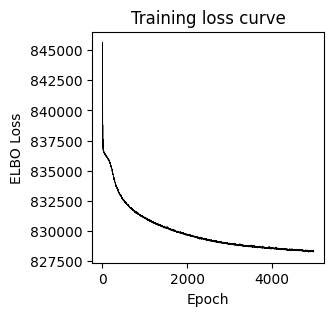

In [11]:
# fit the model 

# setup the optimizer
adam_args = {"lr": 2e-3}
optimizer = Adam(adam_args)
NUM_EPOCHS = 5000

# setup the inference algorithm
loss_method = Trace_ELBO(num_particles=10, vectorize_particles=True)
svi = SVI(vae.model, vae.guide, optimizer, loss=loss_method)

# training loop

train_elbo = train_loop_full_dataset(
    svi, 
    xs_raw,
    xtime_raw,
    utime_raw,
    NUM_EPOCHS
)

# plot the training loss curve
train_elbo_vals = [x[1] for x in train_elbo]

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(train_elbo_vals, linewidth=0.5, color='k')
ax.set_title("Training loss curve")
ax.set_xlabel("Epoch")
ax.set_ylabel("ELBO Loss")


## 3. Visualize the results

Cluster 0: most common cell type: T1 (15495 cells)
Cluster 1: most common cell type: T2 (26037 cells)
Cluster 2: most common cell type: MZ (3582 cells)
Cluster 3: most common cell type: FM (3095 cells)


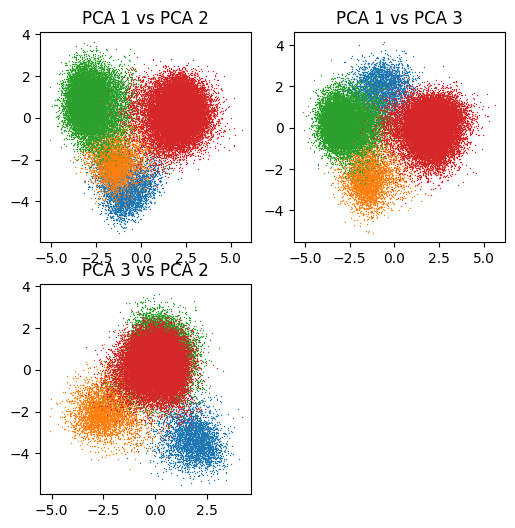

In [12]:
## infer cell types 

with torch.no_grad():
    zs_tensor = vae.dimension_reduction(xs_tensor, ts_tensor).cpu()
    zs_raw = zs_tensor.numpy()

# do PCA on the latent space
pca = PCA(n_components=3)
pca.fit(zs_raw)
zs_pca = pca.transform(zs_raw)


with torch.no_grad():
    clus = vae.classifier(xs_tensor, ts_tensor, method='sample')
clus = clus.cpu().numpy()

# find the ground truth cell types that are most represented in each inferred cluster
# make a dictionary to translate cluster indices to cell type names
translation_dict = {}
celltypes = dataset["CellType"].values
celltypes_unique = sorted(dataset["CellType"].unique()) 
for clus_idx in range(vae.num_clus):
    celltype_counts = {}
    for ct in celltypes_unique:
        celltype_counts[ct] = np.sum((clus == clus_idx) & (celltypes == ct))
    most_common_celltype = max(celltype_counts, key=celltype_counts.get)
    print(f"Cluster {clus_idx}: most common cell type: {most_common_celltype} ({celltype_counts[most_common_celltype]} cells)")
    translation_dict[clus_idx] = most_common_celltype
# map inferred cluster indices to cell type names
clus_names = [translation_dict[clus_idx] for clus_idx in clus]

# define a permutation of cluster indices based on alphabetical order of cell type names
permutation = sorted(translation_dict.keys(), key=lambda k: translation_dict[k])

# re-index clusters to have consistent colors
new_clus = np.zeros_like(clus)
for new_idx, clus_idx in enumerate(permutation):
    new_clus[clus == clus_idx] = new_idx
clus = new_clus


# visualize inferred cell types in PCA space

fig, axs = plt.subplots(2, 2, figsize=(6, 6))

cols = list(TABLEAU_COLORS.values())

for clus_idx in range(vae.num_clus):
    ax = axs[0, 0]
    ax.scatter(zs_pca[clus == clus_idx, 0], zs_pca[clus == clus_idx, 1], s=1,
               linewidths=0, c=cols[clus_idx])
    ax.set_title('PCA 1 vs PCA 2')
    ax = axs[0, 1]
    ax.scatter(zs_pca[clus == clus_idx, 0], zs_pca[clus == clus_idx, 2], s=1,
                linewidths=0, c=cols[clus_idx])
    ax.set_title('PCA 1 vs PCA 3')
    ax = axs[1, 0]
    ax.scatter(zs_pca[clus == clus_idx, 2], zs_pca[clus == clus_idx, 1], s=1,
                linewidths=0, c=cols[clus_idx])
    ax.set_title('PCA 3 vs PCA 2')

axs[1, 1].set_visible(False)

In [13]:
## sample Q values from the fitted model

from pyro.infer import Predictive

predictive = Predictive(
    vae.model, guide=vae.guide, num_samples=100, 
    return_sites=["X0", "Qoffdiag"],
    parallel=True
)

samples = predictive(
    xs_tensor, 
    xtime_tensor, 
    utime_tensor, 
    N=torch.tensor(n_samples, device=DEVICE)
)

Qoffdiag_samples = samples["Qoffdiag"].cpu().numpy().squeeze()
weights_samples = samples["X0"].cpu().numpy().squeeze()

## apply the permutation to the Q matrices and weights

weights_samples_permuted = weights_samples[:, permutation]


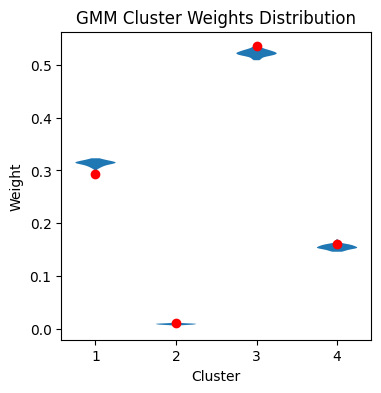

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))

violins = ax.violinplot(weights_samples_permuted, showmeans=False, showextrema=False)
for pc in violins['bodies']:
    pc.set_facecolor('tab:blue')
    pc.set_alpha(1)

ax.set_xlabel("Cluster")
ax.set_ylabel("Weight")
ax.set_title("GMM Cluster Weights Distribution")

# compare with true weights at time 0

cts_t0 = dataset[dataset['Timepoint'] == utime_raw[0]]['CellType'].values

true_weights = [
    np.sum(cts_t0 == ct) / len(cts_t0) 
    for ct in sorted(celltypes_unique)
]

ax.scatter(np.arange(1, vae.num_clus + 1), true_weights, color='red', label='True Weights', zorder=10)


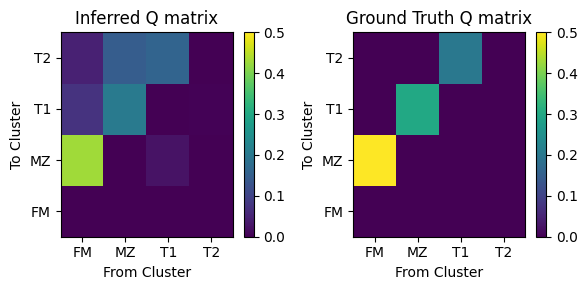

In [15]:
from scdynsys.dynamic_model import build_Q_mat

# import ground truth Q matrix

Q_gt_df = pd.read_csv('../data/simulated_time_series_Q_matrix.csv', index_col=0)

Q_gt = Q_gt_df.values

Q_gt_zero_diag = Q_gt.copy()
np.fill_diagonal(Q_gt_zero_diag, 0)

# plot Q

Qoffdiag_samples = samples["Qoffdiag"].cpu().squeeze()
Q_samples = build_Q_mat(Qoffdiag_samples).numpy()

# apply permutation to Q matrices

Q_samples_permuted = Q_samples[:, permutation, :][:, :, permutation]

meanQ = np.mean(Q_samples_permuted, axis=0)
# set diagonal entries to zero 
np.fill_diagonal(meanQ, 0)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
ax = axs[0]
im = ax.pcolor(meanQ, cmap='viridis', vmin=0, vmax=np.max(Q_gt))
fig.colorbar(im, ax=ax)

# plot the ground true Q matrix for comparison
ax = axs[1]

im = ax.pcolor(Q_gt_zero_diag, cmap='viridis')
fig.colorbar(im, ax=ax)

axs[0].set_title("Inferred Q matrix")
axs[1].set_title("Ground Truth Q matrix")

for ax in axs:
    ax.set_xlabel("From Cluster")
    ax.set_ylabel("To Cluster")
    ticks = np.arange(0.5, vae.num_clus + 0.5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(celltypes_unique)
    ax.set_yticklabels(celltypes_unique)

fig.tight_layout()


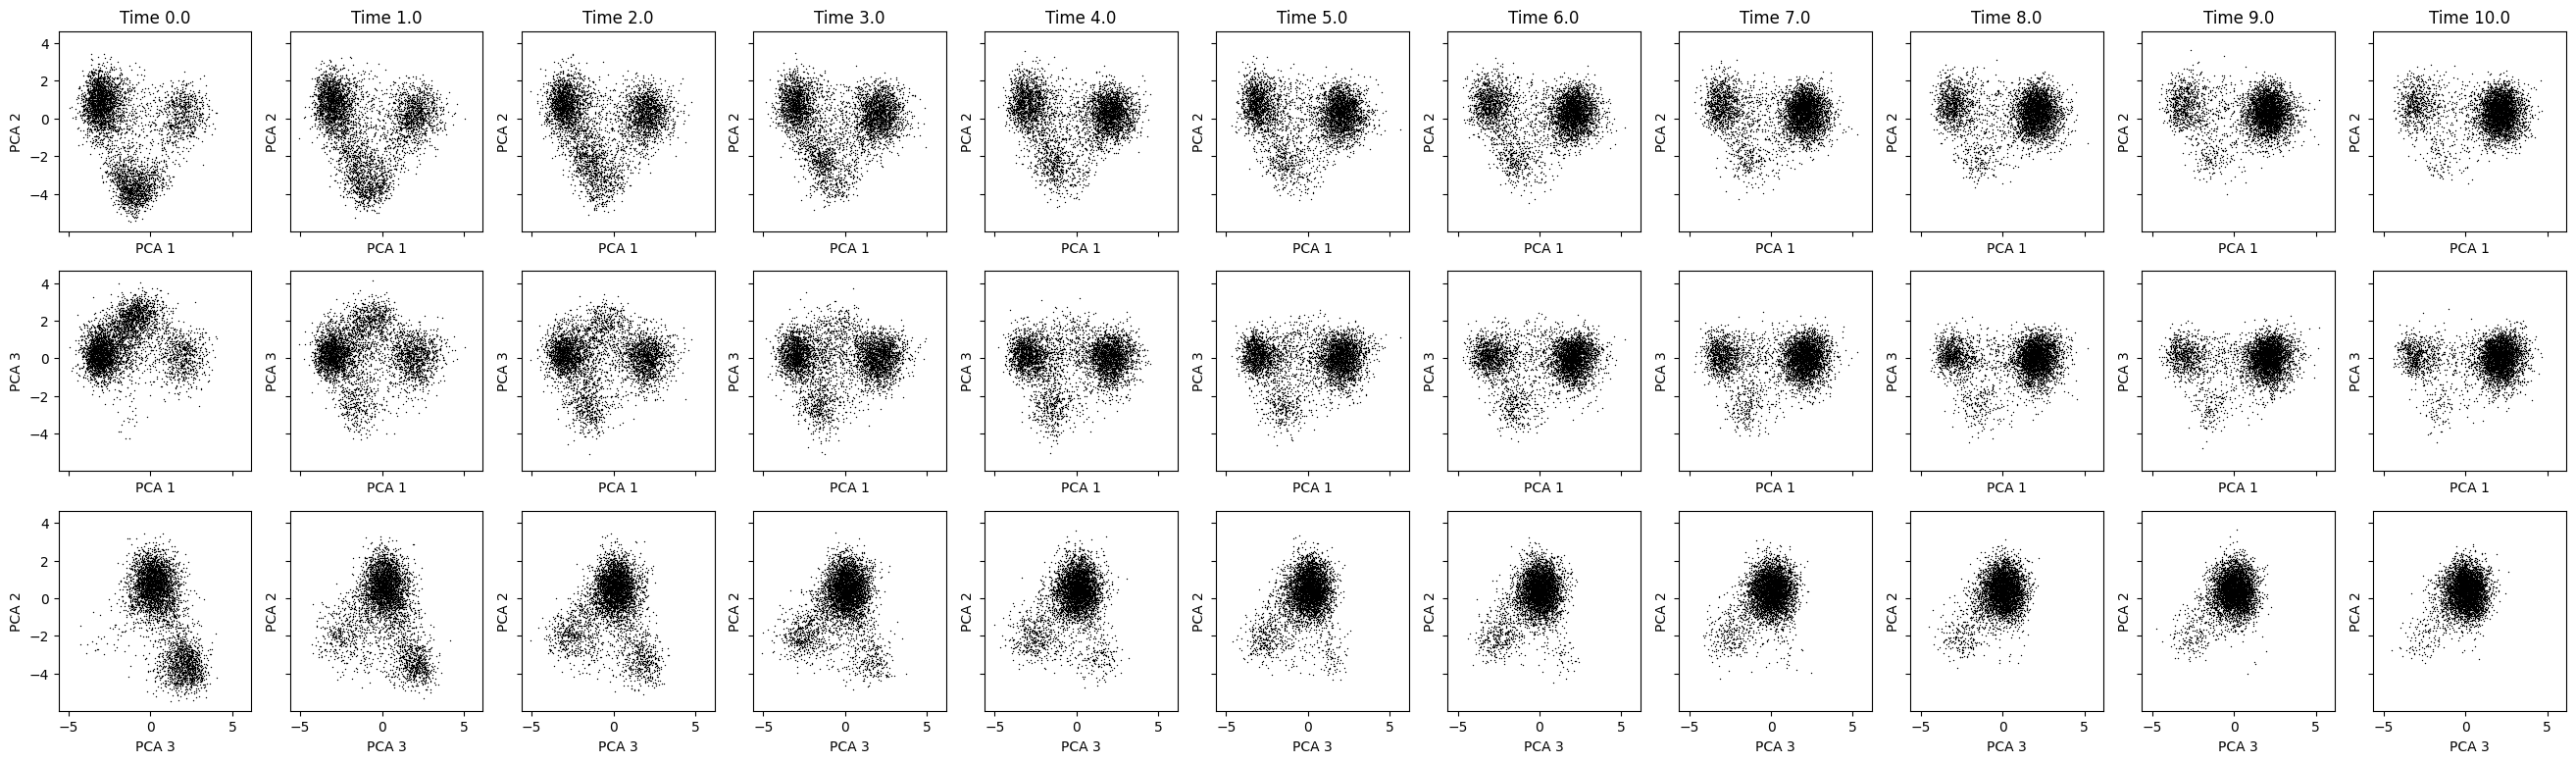

In [20]:
## plot latents space embeddings for each time points

with torch.no_grad():
    zs_tensor = vae.dimension_reduction(xs_tensor, ts_tensor).cpu()
    zs_raw = zs_tensor.numpy()

# do PCA on the latent space
pca = PCA(n_components=3)
pca.fit(zs_raw)
zs_pca = pca.transform(zs_raw)

# plot PCA 1 and 2 in different panels as a function of time

fig, axs = plt.subplots(3, num_timepoints, figsize=(3*num_timepoints, 9), 
                        sharey=True, sharex=True)

for t_idx in range(num_timepoints):
    ax1, ax2, ax3 = axs[:, t_idx]
    time_mask = (xtime_raw == t_idx)
    ax1.scatter(zs_pca[time_mask, 0], zs_pca[time_mask, 1], s=1, alpha=1,
                   linewidths=0, c='k')
    ax2.scatter(zs_pca[time_mask, 0], zs_pca[time_mask, 2], s=1, alpha=1,
                   linewidths=0, c='k')
    ax3.scatter(zs_pca[time_mask, 2], zs_pca[time_mask, 1], s=1, alpha=1,
                   linewidths=0, c='k')
    ax1.set_title(f'Time {utime_raw[t_idx]}')
    ax1.set(xlabel='PCA 1', ylabel='PCA 2')
    ax2.set(xlabel='PCA 1', ylabel='PCA 3')
    ax3.set(xlabel='PCA 3', ylabel='PCA 2')


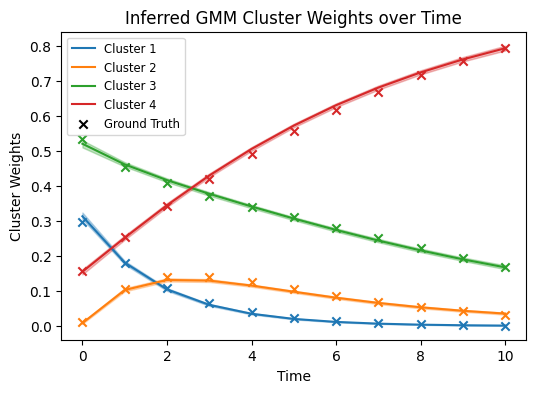

In [17]:
## import ground truth weights for comparison

ground_truth_weights = pd.read_csv('../data/simulated_time_series_ground_truth_weights.csv')

## simulate trajectories from the fitted model

ws_samples = vae.sample_trajectories(
    n=100,
    ts=utime_tensor,    
)

ws_samples_raw = ws_samples.cpu().numpy()

## apply permutation to the weights
ws_samples_raw = ws_samples_raw[:, :, permutation]

mean_ws = np.mean(ws_samples_raw, axis=0)
lower_ws = np.percentile(ws_samples_raw, 5, axis=0)
upper_ws = np.percentile(ws_samples_raw, 95, axis=0)

fig, ax = plt.subplots(figsize=(6, 4))
for i in range(vae.num_clus):
    ax.plot(utime_raw, mean_ws[:, i], label=f"Cluster {i+1}", color=list(TABLEAU_COLORS.values())[i])
    ax.fill_between(utime_raw, lower_ws[:, i], upper_ws[:, i], color=list(TABLEAU_COLORS.values())[i], alpha=0.3)

    ax.scatter(ground_truth_weights['Timepoint'], ground_truth_weights[f'Cluster_{i}_Weight'],
               color=list(TABLEAU_COLORS.values())[i], marker='x')
    
ax.set_xlabel("Time")
ax.set_ylabel("Cluster Weights")
ax.set_title("Inferred GMM Cluster Weights over Time")

# add ground truth legend
ax.scatter([], [], color='k', marker='x', label='Ground Truth')

ax.legend(fontsize='small', loc='upper left')

### Show differentiation pathways between clusters

Next, we will give a visual representation of how cells develop. For this, we will plot the cluster centers (locations) in the latent space (after applying PCA),
together with arrows indicating differentiation between the cell types.

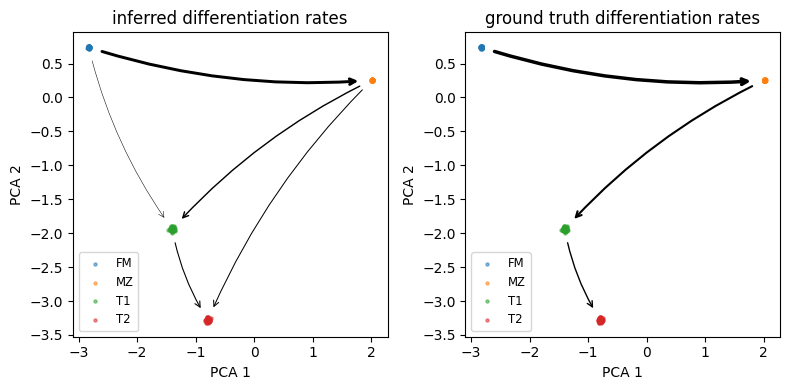

In [18]:
## make a diagram with differentation rates 

loc_pred = Predictive(vae.mix, guide=vae.mix.guide,
                      num_samples=100, parallel=True, return_sites=["clus_locs"])
loc_samples = loc_pred()["clus_locs"].cpu().numpy()

# apply the PCA transformation

locs_pca = pca.transform(loc_samples.reshape(-1, vae.z_dim))
locs_pca = locs_pca.reshape(-1, vae.num_clus, vae.z_dim)

# plot the locs in PCA space

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# plot the estimated arrows between the cluster centers in PCA space
ax = axs[0]

def plot_locs(ax, locs_pca):
    for i in range(vae.num_clus):
        ax.scatter(locs_pca[:, i, 0], locs_pca[:, i, 1], s=5, alpha=0.5,
                color=list(TABLEAU_COLORS.values())[i], label=celltypes_unique[i])
        
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.legend(fontsize='small')

plot_locs(axs[0], locs_pca)

# plot arrows between the locs according to the Q matrix
Q_mean = Q_samples_permuted.mean(axis=0)

# make sure that the width of the arrows is proportional to the Q values

def plot_arrows(ax, Q_mean, locs_pca):
    for i in range(vae.num_clus):
        for j in range(vae.num_clus):
            if i != j and Q_mean[i, j] > 0.05:  # threshold for visibility
                start = np.mean(locs_pca[:, i, 0]), np.mean(locs_pca[:, i, 1])
                end = np.mean(locs_pca[:, j, 0]), np.mean(locs_pca[:, j, 1])
                ax.annotate("",
                            xy=start, xycoords='data',
                            xytext=end, textcoords='data',
                            arrowprops=dict(arrowstyle="->", color='k', lw=Q_mean[i, j]*5,
                                            shrinkA=10, shrinkB=10,connectionstyle="arc3,rad=0.1"),
                            )

plot_arrows(axs[0], Q_mean, locs_pca)

# now plot the ground truth arrows

plot_locs(axs[1], locs_pca)
plot_arrows(axs[1], Q_gt, locs_pca)

axs[0].set_title("inferred differentiation rates")
axs[1].set_title("ground truth differentiation rates")

fig.tight_layout()

## 4. Restrict possible differentiation pathways. 

As you can see in the above diagram, The model predicts differentiation pathways that we did not put into the simulated data. Our fitted model allows for $4\times 3 = 12$ possible differentiation pairs (even loops). 

This freedom might not be biologically plausible, and maybe you have some information to restrict some of these pathways. The goal is to put such restrictions in the model. 

The simplest way to do this is to multiply the matrix $Q$ with a binary "mask" matrix $M$, with a 1 indicating that a path is allowed and a 0 that it is not feasible. Note that the multiplication of $Q$ and $M$ is elementwise.

1. Modify the dynamical model to accept a mask matrix $M$.
2. Ass the mask $M$ to the initialization function of the VAE, and make sure it finds it's way to the right functions.
3. Figure out which index pair of $M$ correspond with a cluster index in the model. What happens if you reset parameters and fit the restricted model directly?
4. Experiment with first fitting the unrestricted model ($M_{ij} = 1$), and then re-fitting with a different $M$. 
5. Compare different resticted models in terms of ELBO and goodness of fit (visually). Can you find/select the best fitting model?

In [19]:
# your code here